## Carregamento das Libs

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from os import listdir
from os.path import join
from pydantic import BaseModel
from typing import Union, List
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# seta a semente do experimento
seed = 42
np.random.seed(seed)

## Algumas funcoes importantes

In [4]:
class Data(BaseModel):
    data : Union[None, List] = None
    target : Union[None, List] = None

def achatar_dataframe(df : pd.DataFrame, user : str):
    dict_info = {}
    linhas, largura = df.shape
    
    if linhas > 1:
        dict_info['In Bed Date'] = df['In Bed Date'].iloc[0]
        dict_info['In Bed Time'] = df['In Bed Time'].iloc[0]
        dict_info['Out Bed Date'] = df['Out Bed Date'].iloc[-1]
        dict_info['Out Bed Time'] = df['Out Bed Time'].iloc[-1]
        dict_info['Onset Date'] = df['Onset Date'].iloc[0]
        dict_info['Onset Time'] = df['Onset Time'].iloc[0]
        dict_info['Latency'] = df['Latency'].iloc[-1]
        dict_info['Efficiency'] = df['Efficiency'].sum()
        dict_info['Total Minutes in Bed'] = df['Total Minutes in Bed'].sum()
        dict_info['Total Sleep Time (TST)'] = df['Total Sleep Time (TST)'].sum()
        dict_info['Wake After Sleep Onset (WASO)'] = df['Wake After Sleep Onset (WASO)'].sum()
        dict_info['Number of Awakenings'] = df['Number of Awakenings'].sum()
        dict_info['Average Awakening Length'] = df['Average Awakening Length'].sum() / linhas
        dict_info['Movement Index'] = df['Movement Index'].sum()
        dict_info['Fragmentation Index'] = df['Fragmentation Index'].sum()
        dict_info['user'] = user

        df = pd.DataFrame([dict_info])
    else:
        df['user'] = user
    return df

def leitura_dos_dados():
    # Carregar a base e pré-processar
    path_root = "/home/hygo/OneDrive/Documentos/Pós/Super/SUPER-2024/Anotacoes/Nicolly/ArtigosSono_Baseline/MMASH/DataPaper/"
    file_data = "sleep_ufam.csv"
    file_target = "questionnaire.csv"
    
    l_df_data = []
    l_df_target = []
    for user in listdir(path_root):
        try:
            print(f"Lendo os arquivos de: /{join(user, file_data)} e /{join(user, file_target)}")
            df_data = pd.read_csv(join(path_root, user, file_data))
            df_target = pd.read_csv(join(path_root, user, file_target))
            
            df_data = achatar_dataframe(df_data.copy(), user)
            
            df_target['user'] = user
            if 'Unnamed: 0' in df_data.columns:
                df_data.drop(['Unnamed: 0'], axis=1, inplace=True)
    
            if df_data.shape[0] == 0:
                continue
                
            l_df_data.append(df_data)
            l_df_target.append(df_target)
        except Exception as e:
            print(f'Erro ao ler os dados do usuário: {user}')
    else:
        df_data = pd.concat(l_df_data, axis=0)
        df_target = pd.concat(l_df_target, axis=0)
    
    return df_data, df_target

# Function to convert time to a continuous value between 0 and 1
def time_to_fraction_of_day(time_str):
    # Split the time string (hh:mm) into hours and minutes
    hours, minutes, seconds = map(int, time_str.split(':'))
    
    # Convert the time into minutes since the start of the day
    total_minutes = hours * 60 + minutes
    
    # Normalize by dividing by total minutes in a day (24 hours * 60 minutes)
    fraction_of_day = total_minutes / (24 * 60)
    
    return fraction_of_day

def make_label(x : float):
    if x < 6:
        return 1
    return 0

def extract_process_info(df_data : pd.DataFrame, df_targets : pd.DataFrame):
    # # Calculate the ratio of Total Sleep Time to Total Time in Bed
    # df_data['Sleep Efficiency'] = df_data['Total Sleep Time (TST)'] / df_data['Total Minutes in Bed']
    
    # # Calculate the ratio of Movement Index to Fragmentation Index
    # df_data['Movement to Fragmentation Ratio'] = df_data['Movement Index'] / df_data['Fragmentation Index']
    
    # Apply the transformation to the time columns
    df_data['In Bed Fraction'] = df_data['In Bed Time'].apply(time_to_fraction_of_day)
    df_data['Out Bed Fraction'] = df_data['Out Bed Time'].apply(time_to_fraction_of_day)
    df_data['Onset Fraction'] = df_data['Onset Time'].apply(time_to_fraction_of_day)
    
    # Apply sine and cosine transformations to capture the cyclic nature of time
    df_data['In Bed Cos'] = np.cos(2 * np.pi * df_data['In Bed Fraction'])
    df_data['In Bed Sin'] = np.sin(2 * np.pi * df_data['In Bed Fraction'])
    
    df_data['Out Bed Cos'] = np.cos(2 * np.pi * df_data['Out Bed Fraction'])
    df_data['Out Bed Sin'] = np.sin(2 * np.pi * df_data['Out Bed Fraction'])
    
    df_data['Onset Cos'] = np.cos(2 * np.pi * df_data['Onset Fraction'])
    df_data['Onset Sin'] = np.sin(2 * np.pi * df_data['Onset Fraction'])

    # df_data['STAI2'] = df_targets['STAI2']

    # Change possibles values reach for NaN
    df_data.fillna(0.00, inplace=True)

    return df_data, df_targets['Pittsburgh'].apply(make_label).values

## Carregamento e Processamento dos dados

In [5]:
df_data, df_targets = leitura_dos_dados()

Lendo os arquivos de: /user_19/sleep_ufam.csv e /user_19/questionnaire.csv
Lendo os arquivos de: /user_15/sleep_ufam.csv e /user_15/questionnaire.csv
Lendo os arquivos de: /user_9/sleep_ufam.csv e /user_9/questionnaire.csv
Lendo os arquivos de: /user_17/sleep_ufam.csv e /user_17/questionnaire.csv
Lendo os arquivos de: /user_2/sleep_ufam.csv e /user_2/questionnaire.csv
Lendo os arquivos de: /user_11/sleep_ufam.csv e /user_11/questionnaire.csv
Lendo os arquivos de: /user_20/sleep_ufam.csv e /user_20/questionnaire.csv
Lendo os arquivos de: /user_13/sleep_ufam.csv e /user_13/questionnaire.csv
Lendo os arquivos de: /user_12/sleep_ufam.csv e /user_12/questionnaire.csv
Lendo os arquivos de: /user_21/sleep_ufam.csv e /user_21/questionnaire.csv
Lendo os arquivos de: /user_18/sleep_ufam.csv e /user_18/questionnaire.csv
Lendo os arquivos de: /user_7/sleep_ufam.csv e /user_7/questionnaire.csv
Lendo os arquivos de: /user_4/sleep_ufam.csv e /user_4/questionnaire.csv
Lendo os arquivos de: /user_10/sl

In [6]:
X_data, y_targets = extract_process_info(df_data, df_targets)

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_data)

,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,user,Sleep Fragmentation Index,In Bed Fraction,Out Bed Fraction,Onset Fraction,In Bed Cos,In Bed Sin,Out Bed Cos,Out Bed Sin,Onset Cos,Onset Sin
0,1900-01-01,22:48:00,1900-01-02,08:09:00,1900-01-01,22:57:00,189.0,185.663459,548.0,295,66,40,1.646914,114.336541,185.663459,user_19,0.000000,0.950000,0.339583,0.956250,0.951057,-0.309017,-0.533615,0.845728,0.962455,-0.271440
0,1900-01-02,00:34:00,1900-01-02,06:55:00,1900-01-02,01:08:00,42.0,130.532915,376.0,244,78,28,2.785714,67.478448,132.521552,user_15,0.000000,0.023611,0.288194,0.047222,0.989016,0.147809,-0.237686,0.971342,0.956305,0.292372
0,1900-01-02,00:02:00,1900-01-02,09:20:00,1900-01-02,00:33:00,31.0,89.964158,558.0,502,8,3,2.666667,6.015038,93.984962,user_9,0.064000,0.001389,0.388889,0.022917,0.999962,0.008727,-0.766044,0.642788,0.989651,0.143493
0,1900-01-02,00:31:00,1900-01-02,06:03:00,1900-01-02,00:35:00,4.0,76.506024,332.0,254,78,16,4.875000,23.493976,76.506024,user_17,0.307087,0.021528,0.252083,0.024306,0.990866,0.134851,-0.013090,0.999914,0.988362,0.152123
0,1900-01-02,00:54:00,1900-01-02,06:22:00,1900-01-02,00:54:00,99.0,98.866442,327.0,161,43,11,4.000000,61.844500,138.155500,user_2,0.000000,0.037500,0.265278,0.037500,0.972370,0.233445,-0.095846,0.995396,0.972370,0.233445
0,1900-01-02,03:21:00,1900-01-02,08:11:00,1900-01-02,03:48:00,27.0,70.689655,290.0,205,64,16,4.000000,29.310345,70.689655,user_11,0.414634,0.139583,0.340972,0.158333,0.639439,0.768842,-0.540974,0.841039,0.544639,0.838671
0,1900-01-02,01:14:00,1900-01-02,07:31:00,1900-01-02,01:14:00,0.0,83.023873,377.0,313,52,14,3.714286,14.010989,85.989011,user_20,0.162939,0.051389,0.313194,0.051389,0.948324,0.317305,-0.386711,0.922201,0.948324,0.317305
0,1900-01-01,23:32:00,1900-01-02,07:00:00,1900-01-01,23:44:00,0.0,150.944318,369.0,246,116,16,7.133333,49.055682,150.944318,user_13,0.000000,0.980556,0.291667,0.988889,0.992546,-0.121869,-0.258819,0.965926,0.997564,-0.069756
0,1900-01-02,00:24:00,1900-01-02,07:01:00,1900-01-02,00:24:00,0.0,79.848866,397.0,317,81,18,4.500000,20.151134,79.848866,user_12,0.252366,0.016667,0.292361,0.016667,0.994522,0.104528,-0.263031,0.964787,0.994522,0.104528
0,1900-01-01,14:38:00,1900-01-02,07:16:00,1900-01-01,14:38:00,0.0,179.931973,315.0,256,63,14,2.178571,20.068027,179.931973,user_21,0.000000,0.609722,0.302778,0.609722,-0.771625,-0.636078,-0.325568,0.945519,-0.771625,-0.636078


In [8]:
cols_valids_baseline = ['Total Minutes in Bed', 
                        'Latency', 
                        'Efficiency', 
                        'Wake After Sleep Onset (WASO)', 
                        'Number of Awakenings',
                        'Average Awakening Length',
                        'Movement Index', 
                        'Fragmentation Index', 
                        'Sleep Fragmentation Index',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos',
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']


cols_valids_baseline = ['Total Minutes in Bed',
                        'Latency',
                        'Efficiency',
                        'Wake After Sleep Onset (WASO)',
                        'Number of Awakenings',
                        'Average Awakening Length',
                        'Movement Index',
                        'Fragmentation Index',
                        'Sleep Fragmentation Index',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos',
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']

cols_valids_baseline = ['Latency',
                        'Efficiency', 
                        'Total Minutes in Bed',
                        'Total Sleep Time (TST)',
                        'Wake After Sleep Onset (WASO)', 
                        'Number of Awakenings', 
                        'Average Awakening Length',
                        'Movement Index', 
                        'Fragmentation Index', 
                        'user', 
                        'Sleep Fragmentation Index',
                        'In Bed Fraction', 
                        'Out Bed Fraction',
                        'Onset Fraction',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos', 
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']

### Seleção das variáveis segungo o Baseline

In [9]:
X_data = X_data[cols_valids_baseline]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_data)

,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,user,Sleep Fragmentation Index,In Bed Fraction,Out Bed Fraction,Onset Fraction,In Bed Cos,In Bed Sin,Out Bed Cos,Out Bed Sin,Onset Cos,Onset Sin
0,189.0,185.663459,548.0,295,66,40,1.646914,114.336541,185.663459,user_19,0.000000,0.950000,0.339583,0.956250,0.951057,-0.309017,-0.533615,0.845728,0.962455,-0.271440
0,42.0,130.532915,376.0,244,78,28,2.785714,67.478448,132.521552,user_15,0.000000,0.023611,0.288194,0.047222,0.989016,0.147809,-0.237686,0.971342,0.956305,0.292372
0,31.0,89.964158,558.0,502,8,3,2.666667,6.015038,93.984962,user_9,0.064000,0.001389,0.388889,0.022917,0.999962,0.008727,-0.766044,0.642788,0.989651,0.143493
0,4.0,76.506024,332.0,254,78,16,4.875000,23.493976,76.506024,user_17,0.307087,0.021528,0.252083,0.024306,0.990866,0.134851,-0.013090,0.999914,0.988362,0.152123
0,99.0,98.866442,327.0,161,43,11,4.000000,61.844500,138.155500,user_2,0.000000,0.037500,0.265278,0.037500,0.972370,0.233445,-0.095846,0.995396,0.972370,0.233445
0,27.0,70.689655,290.0,205,64,16,4.000000,29.310345,70.689655,user_11,0.414634,0.139583,0.340972,0.158333,0.639439,0.768842,-0.540974,0.841039,0.544639,0.838671
0,0.0,83.023873,377.0,313,52,14,3.714286,14.010989,85.989011,user_20,0.162939,0.051389,0.313194,0.051389,0.948324,0.317305,-0.386711,0.922201,0.948324,0.317305
0,0.0,150.944318,369.0,246,116,16,7.133333,49.055682,150.944318,user_13,0.000000,0.980556,0.291667,0.988889,0.992546,-0.121869,-0.258819,0.965926,0.997564,-0.069756
0,0.0,79.848866,397.0,317,81,18,4.500000,20.151134,79.848866,user_12,0.252366,0.016667,0.292361,0.016667,0.994522,0.104528,-0.263031,0.964787,0.994522,0.104528
0,0.0,179.931973,315.0,256,63,14,2.178571,20.068027,179.931973,user_21,0.000000,0.609722,0.302778,0.609722,-0.771625,-0.636078,-0.325568,0.945519,-0.771625,-0.636078


In [10]:
# Preprocess the data: Standardize the features (important for SVM, KNN)
scaler = StandardScaler()

feats = ['Total Minutes in Bed', 'Latency', 'Efficiency', 'Wake After Sleep Onset (WASO)', 'Number of Awakenings', 
         'Average Awakening Length', 'Movement Index', 'Fragmentation Index', 'Sleep Fragmentation Index', 
         'In Bed Cos', 'In Bed Sin', 'Out Bed Cos', 'Out Bed Sin', 'Onset Cos', 'Onset Sin']

X_scaled = scaler.fit_transform(X_data[feats])
X_scaled_df = pd.DataFrame(data=X_scaled, columns=feats)

# X_scaled_df['In Bed Cos'] = X_data['In Bed Cos'].values
# X_scaled_df['In Bed Sin'] = X_data['In Bed Sin'].values
# X_scaled_df['Out Bed Cos'] = X_data['Out Bed Cos'].values
# X_scaled_df['Out Bed Sin'] = X_data['Out Bed Sin'].values
# X_scaled_df['Onset Cos'] = X_data['Onset Cos'].values
# X_scaled_df['Onset Sin'] = X_data['Onset Sin'].values

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_scaled_df)

,Total Minutes in Bed,Latency,Efficiency,Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index,In Bed Cos,In Bed Sin,Out Bed Cos,Out Bed Sin,Onset Cos,Onset Sin
0,2.126857,3.258424,1.400504,-0.144520,2.952660,-1.840033,2.900072,1.248355,-0.935038,0.460424,-0.906567,-1.102398,-0.941819,0.488740,-0.878355
1,-0.089009,0.181711,0.339134,0.326508,1.377908,-0.926156,1.090866,0.240115,-0.935038,0.520378,0.231497,0.282143,0.525005,0.478980,0.501591
2,2.255687,-0.048520,-0.441893,-2.421158,-1.902825,-1.021690,-1.282256,-0.491025,-0.552008,0.537667,-0.114992,-2.189852,-3.311594,0.531899,0.137205
3,-0.655859,-0.613630,-0.700988,0.326508,-0.196844,0.750478,-0.607389,-0.822646,0.902828,0.523300,0.199214,1.332947,0.858649,0.529852,0.158329
4,-0.720274,1.374722,-0.270506,-1.047325,-0.852991,0.048298,0.873338,0.347005,-0.935038,0.494087,0.444837,0.945761,0.805890,0.504474,0.357367
5,-1.196943,-0.132240,-0.812964,-0.223025,-0.196844,0.048298,-0.382817,-0.932997,1.546484,-0.031759,1.778638,-1.136832,-0.996571,-0.174312,1.838672
6,-0.076127,-0.697350,-0.575506,-0.694053,-0.459303,-0.180985,-0.973530,-0.642729,0.040129,0.456107,0.653750,-0.415090,-0.048826,0.466314,0.562615
7,-0.179190,-0.697350,0.732093,1.818098,-0.196844,2.562771,0.379557,0.589643,-0.935038,0.525954,-0.440337,0.183269,0.461758,0.544456,-0.384728
8,0.181532,-0.697350,-0.636631,0.444265,0.065615,0.449544,-0.736457,-0.759223,0.575333,0.529075,0.123674,0.163562,0.448464,0.539629,0.041839
9,-0.874869,-0.697350,1.290162,-0.262277,-0.459303,-1.413382,-0.739665,1.139614,-0.935038,-2.260455,-1.721355,-0.129025,0.223459,-2.263154,-1.770816


In [12]:
X_scaled = X_scaled_df.values

### Aplicando SMOTE

In [70]:
# Aplicação do SMOTE para balanceamento das classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_targets)

### Sem aplicação do SMOTE

### Aplicação do Random Forest

In [14]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

<BarContainer object of 16 artists>

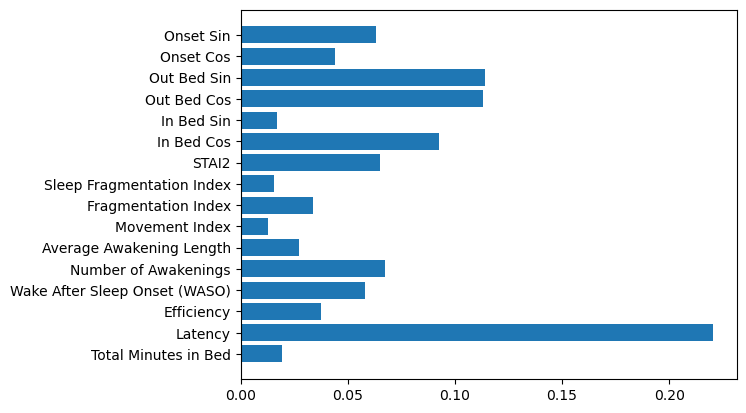

In [15]:
plt.barh(X_scaled_df.columns, rf.feature_importances_)

Text(0.5, 0, 'Características mais revelantes')

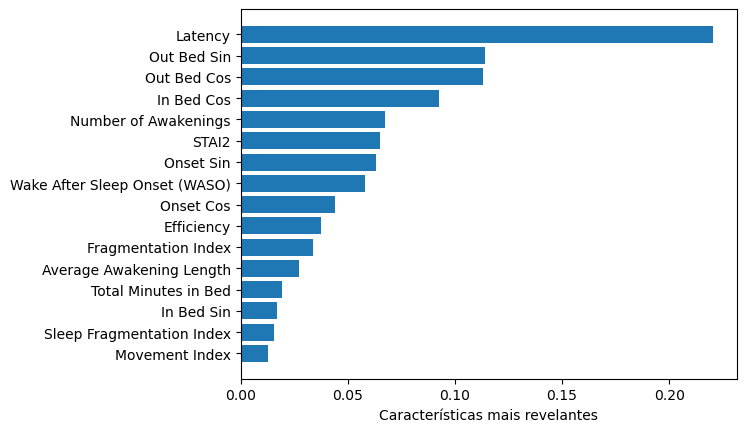

In [16]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_scaled_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Características mais revelantes")

### Aplicação do RFE

In [13]:
from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
# get a list of models to evaluate
from sklearn.pipeline import Pipeline

In [14]:
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_scaled_df, y_targets, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/home/hygo/anaconda3/envs/ExpNicolly/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/hygo/anaconda3/envs/ExpNicolly/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/hygo/anaconda3/envs/ExpNicolly/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.572 (0.315)


In [15]:
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8)
# fit RFE
rfe.fit(X_scaled_df, y_targets)
# summarize all features
for i in range(X_scaled_df.shape[1]):
	print('Column: %s, Selected [%s], Rank: %.3f' % (X_scaled_df.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: Total Minutes in Bed, Selected [False], Rank: 7.000
Column: Latency, Selected [False], Rank: 8.000
Column: Efficiency, Selected [False], Rank: 5.000
Column: Wake After Sleep Onset (WASO), Selected [False], Rank: 6.000
Column: Number of Awakenings, Selected [False], Rank: 4.000
Column: Average Awakening Length, Selected [False], Rank: 3.000
Column: Movement Index, Selected [False], Rank: 2.000
Column: Fragmentation Index, Selected [True], Rank: 1.000
Column: Sleep Fragmentation Index, Selected [True], Rank: 1.000
Column: In Bed Cos, Selected [True], Rank: 1.000
Column: In Bed Sin, Selected [True], Rank: 1.000
Column: Out Bed Cos, Selected [True], Rank: 1.000
Column: Out Bed Sin, Selected [True], Rank: 1.000
Column: Onset Cos, Selected [True], Rank: 1.000
Column: Onset Sin, Selected [True], Rank: 1.000


- Column: Movement Index, Selected [True], Rank: 1.000
- Column: STAI2, Selected [True], Rank: 1.000
- Column: In Bed Cos, Selected [True], Rank: 1.000
- Column: In Bed Sin, Selected [True], Rank: 1.000
- Column: Out Bed Cos, Selected [True], Rank: 1.000
- Column: Out Bed Sin, Selected [True], Rank: 1.000
- Column: Onset Cos, Selected [True], Rank: 1.000
- Column: Onset Sin, Selected [True], Rank: 1.000

## Aplicação do PCA para visualização
- Acrescentado o atributo 'Fragmentation Index'

In [16]:
cols_selects = ['Movement Index', 'Fragmentation Index', 'Sleep Fragmentation Index', 'In Bed Cos', 'In Bed Sin', 'Out Bed Cos', 'Out Bed Sin', 'Onset Cos', 'Onset Sin']

X_scaled = X_scaled_df[cols_selects]

In [17]:
## Aplicação do PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# prin_componentes = pca.fit_transform(X_resampled)
prin_componentes = pca.fit_transform(X_scaled)

In [18]:
df_pca = pd.DataFrame(data=prin_componentes, columns = ['PC_1','PC_2'])
# df_pca

In [19]:
df_pca = pd.concat([df_pca, pd.DataFrame(data=y_targets, columns=['target'])], axis=1)
# df_pca

In [20]:
df_pca['target_name'] = df_pca['target'].apply(lambda x : 'ruim' if x == 0 else 'boa')
# df_pca

### Plot 2D

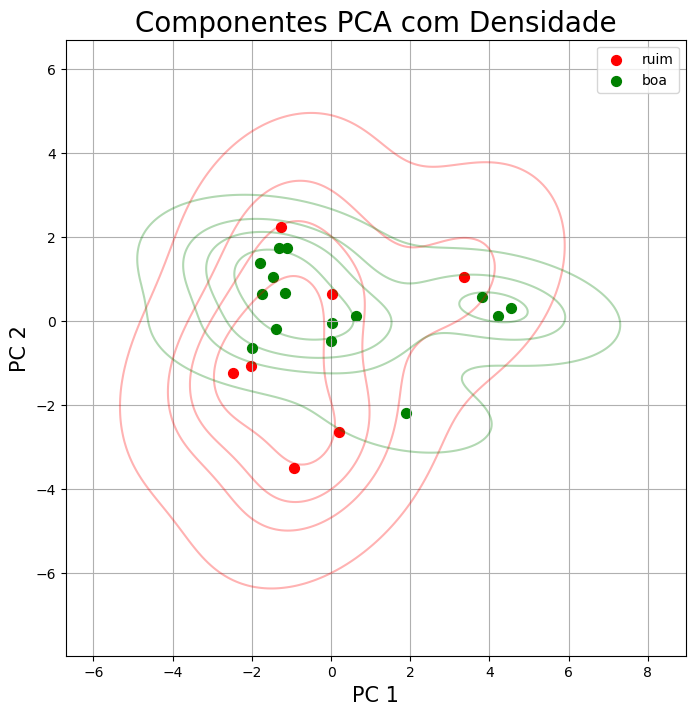

In [21]:
# Supondo que df_pca já existe e contém as colunas 'PC_1', 'PC_2' e 'target_name'
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
ax.set_title('Componentes PCA com Densidade', fontsize=20)

# Definindo targets e cores
targets = ['ruim', 'boa']
colors = ['r', 'g']

# Plotando os pontos e adicionando KDE para cada target
for target, color in zip(targets, colors):
    indicesToKeep = df_pca['target_name'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC_1'],
               df_pca.loc[indicesToKeep, 'PC_2'],
               c=color,
               s=50,
               label=target)
    
    # Adicionando KDE (sombreamento de densidade)
    sns.kdeplot(x=df_pca.loc[indicesToKeep, 'PC_1'],
                y=df_pca.loc[indicesToKeep, 'PC_2'],
                color=color,
                alpha=0.3,  # Transparência do sombreamento
                levels=5,   # Número de curvas de densidade
                ax=ax)

ax.legend(targets)
ax.grid()
plt.show()

In [22]:
fig.savefig("distribuicao_pca_dados_originais_selecionadas.png")

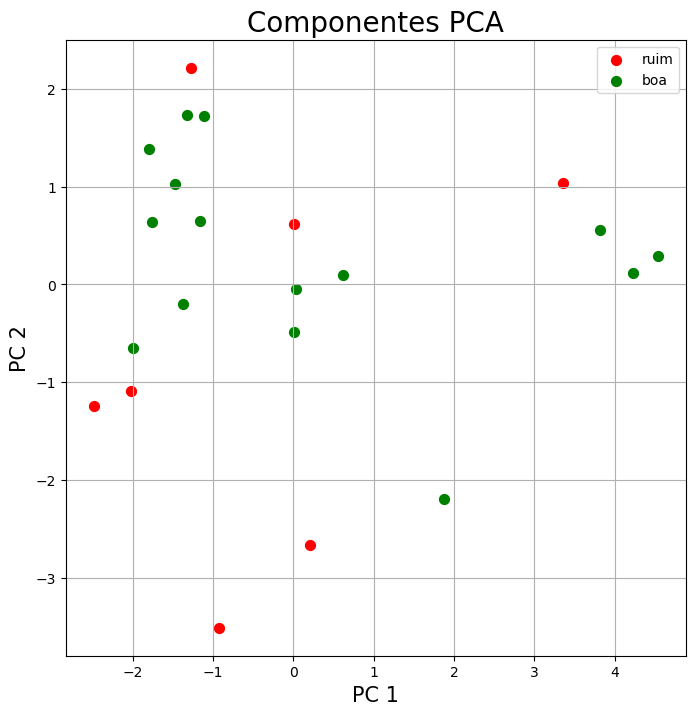

In [23]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Componentes PCA', fontsize = 20)

targets = ['ruim', 'boa']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['target_name'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC_1']
               , df_pca.loc[indicesToKeep, 'PC_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Plot 3D

In [ ]:
# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Color mapping
colors = {'vigilia': 'blue', 'sleep': 'red'}

# Scatter plot
for target_name in df_pca['target_name'].unique():
    subset = df_pca[df_pca['target_name'] == target_name]
    ax.scatter(
        subset['principal component 1'],
        subset['principal component 2'],
        subset['principal component 3'],
        c=colors[target_name],
        label=target_name,
        s=50  # point size
    )

# Labels and title
ax.set_title('Plot of Principal Components distribution')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Legend
ax.legend()

# Show plot
plt.show()

## Maximização das classes

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Applying LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(df_pca[['principal component 1']], df_pca['target'])

# Convert to DataFrame for easy plotting
lda_df = pd.DataFrame(X_lda, columns=['LD1'])
lda_df['target_name'] = df_pca['target_name']

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lda_df, x='LD1', hue='target_name', palette={'vigilia': 'blue', 'sleep': 'red'})
plt.title('LDA Projection for Class Separation')
plt.show()

## Continuação

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_scaled)

In [ ]:
# Define classifiers
classifiers = {
               "Logistic Regression": LogisticRegression(),
               "Support Vector Machine": SVC(),
               "K-Nearest Neighbors": KNeighborsClassifier(),
               "Naive Bayes": GaussianNB(),
               "Neural Network" : MLPClassifier(hidden_layer_sizes=(20,), max_iter=50),
               "Random Forest Classifier" : RandomForestClassifier(n_estimators=50)
              }

In [ ]:
# Define the number of folds
folds = [3,5,8]

# Perform k-fold cross-validation for each classifier and each number of folds
results = {}

for classifier_name, model in classifiers.items():
    print(f"Evaluating {classifier_name}...")
    model_results = {}
    
    for n_folds in folds:
        print(f"  - {n_folds}-fold cross-validation...")
        
        # Define k-fold cross-validation strategy
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)


        # Perform cross-validation
        cv_results = cross_val_score(model,  \
                                     df_pca[['principal component 1', 'principal component 2']].values, \
                                     df_pca['target'].values, \
                                     cv=kfold, \
                                     scoring='accuracy')
        
        # Store the results
        model_results[f"{n_folds}-fold"] = cv_results.mean()
        
        print(f"    Average accuracy for {n_folds}-fold: {cv_results.mean():.4f}")
    
    results[classifier_name] = model_results

# Display the results
print("\nFinal Results:")
for classifier_name, model_results in results.items():
    print(f"\n{classifier_name}:")
    for fold, accuracy in model_results.items():
        print(f"  {fold}: {accuracy:.4f}")